<a href="https://colab.research.google.com/github/julija-dmrk/data-mining/blob/main/1week_corrected_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
# from sklearn import datasets, model_selection
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split

# load data
url="https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv"
data = pd.read_csv(url)

Exploring Data

In [3]:
# first checking for missing values
data.isnull().values.any()

False

In [ ]:
# exploring species distribution
sp = data["Species"].value_counts()
plt.bar(sp.index, sp, width=0.8)
plt.xlabel('Species')
plt.ylabel('Counts of Species')

In [5]:
data = pd.read_csv(url)
y = data["Weight"]
x = pd.get_dummies(data, columns = ['Species']).drop("Weight", axis = 1)
#susidarom vektorius, kurie paaiskina daugiausiai duomenu variacijos (sudaryti is kintamuju tiesines formules)
#konstanta nereikalinga formuoti priklausomaji kintamaji
#PCA turim pateikti skaitines reiksmes, todel kategorinius verciamia i dummy variables 
#one hot encoding

Creating PCA estimators

In [ ]:
# create PCA estimator
pca = PCA()

features_pca = pca.fit_transform(x)
# results
features_pca.shape
# pca = PCA(n_components=x.shape[1], whiten=True)

# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_)

plt.plot(pca_var_ex.index, pca_var_ex, marker = ".")
plt.ylabel("variance explained")
plt.xlabel("number of principal components")
# When we perform a decomposition on, we always emphasize the "most important synthetic features." 
# The result of this for PCA specifically - the variance decreases with each PCA feature.

# There can be a secondary de-emphasis of some features that is too strong. 
# It depends on the specific kind of model used, but for many models a numeric 
# feature ranging from 0 to 100 will simply have more effect than a feature varying 
## from 0 to 1 just because it contributes bigger numbers to the calculation. 
# Usually it is better to let a model select the importances of features than to judge it in advance with feature engineering.

#1PCA explains 100 variance, and others explains almost nothing- it's bad example of PCA
#PCA turi tendencija clusterizuotis, tikriausiai duomenys atsiskiria pagal rusis

In [ ]:
# We can see how the two PCA components are derived by linear combination of the original 30.
pca.components_
#parodo kaip kiekviena komponente susijusi su predictoriais
#vizualizuoti:
nfeat = x.shape[1]
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat), x.columns, rotation=90, ha='left')
plt.xlabel("pca_components") 

#Jei skaleje yra dideles vertes, tai nelygiaverciai koeficientai vieno ir kito kintamojo. Todel visada naudinga
#atlikti standartizavima.

Text(0.5, 0, 'number of principal components')

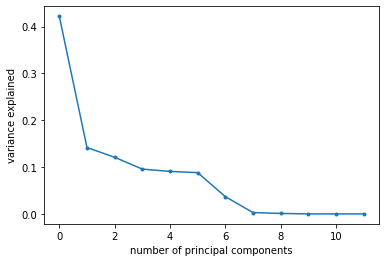

In [15]:
#Standartizavimas
from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(x)
scaled_x.mean(axis = 0) #vertes labai arti nulio, o std -1
scaled_x.std(axis = 0) #z transformacija nunulina vidurki i 0 - suvienodinam std

scaled_y = (y - y.mean()) / y.std()

# create PCA estimator
pca = PCA()
# Conduct PCA
features_scaled_pca = pca.fit_transform(scaled_x)
# Show results
features_scaled_pca.shape

# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_)

plt.plot(pca_var_ex.index, pca_var_ex, marker = ".")
plt.ylabel("variance explained")
plt.xlabel("number of principal components")

In [ ]:
# again composition, bus after scaling
nfeat = x.shape[1]
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
# plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat), x.columns, rotation=90, ha='left')
plt.xlabel("pca_components")
#matome, kad pasikeicia komponentes ir predictoriu sasaja

Prediction models

In [18]:
#testing set
# dirbsim su 90% train data set'o duomenu ir naudosim cross-validation
x, x_out, y, y_out = train_test_split(scaled_x, scaled_y, test_size = 0.1, random_state = 0)
#abejais atvejais duomenys scalinti, tik su x dar PCA
x_pca, x_out_pca, y, y_out = train_test_split(features_scaled_pca, scaled_y, test_size=0.1 , random_state=0)

#resultatai bus prideti i modelio dictionary
model_score = {}

n = scaled_x.shape[1]

In [ ]:
#KNN MODEL - vienintelis neparemtas tiesine regresija
k_range = range(1, n)  #k vertei surasti reikia ciklo
all_scores = []
mean_scores = []
# Calculating error for K values between 1 and 12
# Kiekvienam k_range fitinam modeli, apsiskaiciuojam test cross_validation scores
# KFold - i 10 skilciu suskaidom savo duomenis ir atsikartojamumui turim 1
for i in k_range:
    knn = KNeighborsRegressor(n_neighbors=i)
    scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
    all_scores.append(scores) #apskaiciuojam visas scores
    mean_scores.append(np.mean(scores)) #scores vidurkis

#Pagal vidurki geriausia k_verte - 2, jei didinam kaimynu skaiciu modelis - per lankstus
## testavimo vertes krenta. Isiskiria 3 testavimo setai, kurie nuvertina duomenis
plt.figure(figsize=(12, 6))
plt.plot(k_range, all_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue')
plt.plot(k_range, mean_scores, color='red', linestyle='dashed', marker='o', markerfacecolor='red')
plt.xlabel('K Value')
plt.ylabel('score')

In [ ]:
knn = KNeighborsRegressor(n_neighbors=2)
knn_scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
model_score["knn"] = [knn, knn_scores, knn_scores.mean(), knn_scores.std()]
# i model score issisaugojam visa modeli, pakartojimo testavimo verte ir ju vidurki ir std
## std = 1

In [ ]:
#LASSO MODEL - reikia alfa reiksmes. 

column = pd.get_dummies(data, columns=["Species"]).drop("Weight", axis = 1).columns

# finding out the parameter
lasso_CVm = LassoCV(cv=KFold(10, True, 1), random_state=0, max_iter = 10000)
lasso_CVm.fit(x, y)

lasso_CVm.coef_ #Parodo ar kas buvo nunulinta
column[lasso_CVm.coef_ != 0] # which coeficents are non-zero
lasso_alpha = lasso_CVm.alpha_

# CV the model with parameter. Defaultine verte iteraciju 999, bet 
#pas mus 10000 - bandom rasti tinkama minimuma, kuris mum tinkamas, kartojam daug kartu
#ir ziurim i kokia verte konvertuoja duomenys. Ieskom iteratyviai, o ne pagal formule
#Jei nesueina i 1-a stabilia reiksme tai reiskia arba per mazai pakartojimu arba
#duomenys yra sunkiai modeliuojami. Del tokio erroro pirmiausiai bandom padidinti iteraciju skaiciu
lasso_m = Lasso(alpha = lasso_alpha, random_state=0, max_iter = 10000)
lasso_scores = cross_val_score(lasso_m, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lasso"] = [lasso_m, lasso_scores, lasso_scores.mean(), lasso_scores.std(), column[lasso_CVm.coef_ != 0]]
#model_score po index issirasom kokius papildomus kintamuosius turime

In [ ]:
# Ridge - panasiai kaip lasso, randam coeficientu vertes ir alfa
# finding out the parameter
ridge_CVm = RidgeCV(cv=KFold(10, True, 1))
ridge_CVm.fit(x, y)

ridge_CVm.coef_
pd.DataFrame({"coef":ridge_CVm.coef_, "c": column}).sort_values(by = "coef")
ridge_alpha = ridge_CVm.alpha_

# CV the model with parameter
ridge_m = Ridge(alpha = ridge_alpha)
ridge_scores = cross_val_score(ridge_m, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["ridge"] = [ridge_m, ridge_scores, ridge_scores.mean(), ridge_scores.std()]
#is model score ziurim pagal scores.mean ir matom, jog knn veikia geriausiai

In [44]:
# LINEAR REGRESSION MODEL
regr = LinearRegression() 
regr.fit(x, y)
# LR the model with parameter
regr_scores = cross_val_score(regr, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr full"] = [regr, regr_scores, regr_scores.mean(), regr_scores.std()]
#Pilnas modelis veikia prasciau nei Ridge metodas

# linear regression model with PC - paziurim ar visus musu duomenis gali PCA paaiskinti
regr_pca = LinearRegression()
regr_pca.fit(x_pca[:, 0:6], y)
# LR the model with parameter
regr_pca_scores = cross_val_score(regr_pca, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr_pca"] = [regr_pca, regr_pca_scores, regr_pca_scores.mean(), regr_pca_scores.std(), regr_pca.coef_]

# linear regression model with PC 2 - kadangi lr_pca = lr full - paimam dar dvi PCA komponentas ir matom, kad praktiskai tas pats rezultatas
#PCA vistiek paaiskina didele dali musu duomenu.
regr_pca = LinearRegression()
regr_pca.fit(x_pca[:, 0:1], y)
regr_pca.coef_
# LR the model with parameter
regr_pca_scores = cross_val_score(regr_pca, x, y, cv=KFold(10, True, 1), scoring='neg_mean_squared_error')
model_score["lr_pca_2"] = [regr_pca, regr_pca_scores, regr_pca_scores.mean(), regr_pca_scores.std(), regr_pca.coef_]


{'knn': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='uniform'),
  array([-0.00874593, -0.00699569, -0.02686646, -0.0190393 , -0.06320657,
         -0.01418085, -0.00888817, -0.01190901, -0.01876759, -0.08914292]),
  -0.026774249350816303,
  0.02599384977954183],
 'lasso': [Lasso(alpha=0.0014706045965648745, copy_X=True, fit_intercept=True,
        max_iter=10000, normalize=False, positive=False, precompute=False,
        random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
  array([-0.05897862, -0.06923322, -0.11969678, -0.10444775, -0.10858619,
         -0.05173586, -0.15796483, -0.04181646, -0.05195956, -0.0586541 ]),
  -0.08230733613088789,
  0.03615598564369535,
  Index(['Length2', 'Length3', 'Species_Bream', 'Species_Parkki', 'Species_Pike',
         'Species_Roach', 'Species_Smelt'],
        dtype='object')],
 'lr full': [LinearRegres

Geriausiai veikia Lasso be PCA komponenciu ir KNN